# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
!pip install catboost -q

In [147]:
import numpy as np
import pandas as pd
import re
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
nltk.download('stopwords')
RANDOM_STATE = 0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [148]:
df = pd.read_csv('/content/drive/MyDrive/IAD/6/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
18142,25875,70827,NaN,25-03-2020,Thank you for working hard to keep our shelves...,Positive
24245,33448,78400,"California, USA",05-04-2020,One more thing ÃÂ if you know a single paren...,Negative
14776,21770,66722,"Houston, TX",23-03-2020,"List: Food banks, school districts and some lo...",Extremely Positive
7639,13074,58026,"Guwahati, India",20-03-2020,When the broke out businessmen doubled the pri...,Negative


In [149]:
df.shape

(33444, 6)

Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [150]:
# Посмотрим какие классы присутствуют
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [151]:
# Выполним замену
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if 'Positive' in x else 0)

Сбалансированы ли классы?

In [152]:
balance = df['Sentiment'].value_counts()
balance

,count
Sentiment,
1,18046
0,15398


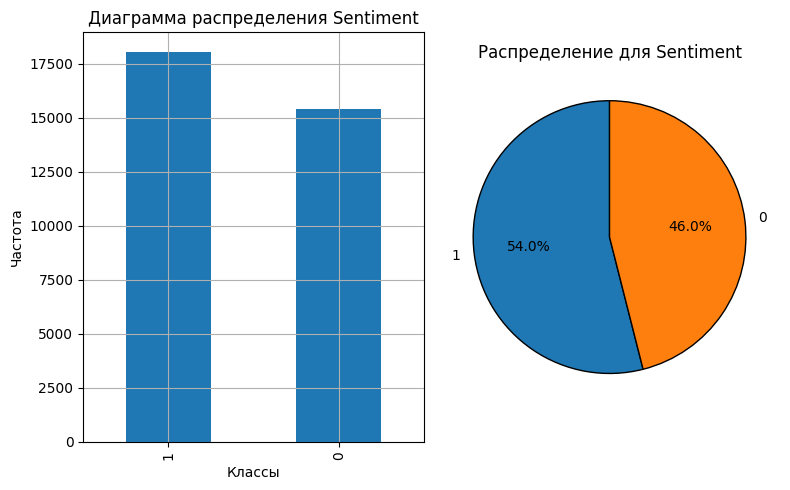

In [153]:
# Построим диаграмму распределения классов и круговую диаграмму для большей наглядности
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

balance.plot.bar(ax=axes[0])
axes[0].set_title(f'Диаграмма распределения Sentiment', fontsize=12)
axes[0].grid(True)
axes[0].set_xlabel('Классы')
axes[0].set_ylabel('Частота')
axes[0].tick_params(axis='x', rotation=90)

balance.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
        ax=axes[1]
    )
axes[1].set_title(f'Распределение для Sentiment', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

**Ответ:** # Как мы видим различие между классами всего 8 процентов, что говорит о том, что данные сбалансированы хорошо

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [154]:
# Посчитаем пропуски
df.isna().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


In [155]:
# Заполним пропуски в столбце Location заглушкой Unknown
df['Location'].fillna('Unknown', inplace=True)

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [156]:
train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)

In [157]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
25621,35178,80130,Unknown,06-04-2020,Why we still want to buy so much stuff during ...,1
30135,40819,85771,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...,1
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,1
5989,11068,56020,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...,0
4367,9109,54061,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh...",1


## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [158]:
text = " ".join(train['OriginalTweet'].astype(str))
text = pd.DataFrame(text.lower().split(), columns=['token']).groupby('token').size().reset_index(name='count').sort_values(by = 'count', ascending=False)

In [159]:
text.head()

,token,count
73832,the,26815
74466,to,23373
23682,and,14684
61303,of,13012
22255,a,11737


Какой размер словаря получился?

In [160]:
text.shape

(79755, 2)

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [161]:
text.head(10)

,token,count
73832,the,26815
74466,to,23373
23682,and,14684
61303,of,13012
22255,a,11737
54031,in,11198
37141,for,8566
2450,#coronavirus,8223
55004,is,7383
24171,are,7050


**Ответ:** # Большинство популярных токенов  это служебные слова, которые не несут в себе смысла, а так же токен #coronavirus, ведь все твиты про корону и этот хештег везде использовали

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [162]:
stop_words = set(stopwords.words('english'))
text = text[~text['token'].isin(stop_words)]
text.head(10)

,token,count
2450,#coronavirus,8223
64813,prices,3891
37006,food,3820
38908,grocery,3469
72648,supermarket,3288
63189,people,3175
30760,covid-19,3173
72019,store,3155
2733,#covid19,2471
11374,&amp;,2314


**Ответ:**  # Теперь мы видим слова, которые люди используют в осбуждениях, говоря о пандемии и некоторые хештеги

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [163]:
text.tail(20)

,token,count
38860,greymouth.,1
38861,grids,1
38863,grievances,1
38864,grieve,1
38916,"grocery.""",1
38873,grimy,1
38875,grinder,1
38877,grinds,1
10319,#viruschines,1
10321,#viruscoronaupdate,1


**Ответ:** # Такие токены это редкие или ошибочные слова. Эти токены не несут полезной информации для анализа, и их можно удалить или обработать



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [164]:
Tokenizer = TweetTokenizer()
text = " ".join(train['OriginalTweet'].astype(str))
text = pd.DataFrame(Tokenizer.tokenize(text.lower()), columns=['token']).groupby('token').size().reset_index(name='count').sort_values(by = 'count', ascending=False)
text.head(10)

,token,count
55216,the,26993
9713,.,24108
55533,to,23478
9690,",",17571
18701,and,14825
47486,of,13044
17745,a,11891
42619,in,11348
11527,?,9524
1743,#coronavirus,8808


**Ответ:** # ТУт повяились знаки препинания, котоые не являются частью слова, а раньше мы разделяли только по пробелам и их не было

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [165]:
punctuation_list = list(punctuation)
text = text[~text['token'].isin(stop_words)]
text = text[~text['token'].isin(punctuation_list)]
text.head(10)

,token,count
1743,#coronavirus,8808
58345,â,7415
58308,,7311
10277,19,7167
23178,covid,6253
49571,prices,4601
58313,,4372
27115,food,4367
54142,store,3877
54499,supermarket,3805


**Ответ:** # Да, остались непонятные символы

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [166]:
text = text[~text['token'].apply(lambda x: len(x) == 1 and ord(x) >= 128)]
text.head(10)

,token,count
1743,#coronavirus,8808
10277,19,7167
23178,covid,6253
49571,prices,4601
27115,food,4367
54142,store,3877
54499,supermarket,3805
28303,grocery,3523
48558,people,3463
1955,#covid19,2589


In [167]:
text.tail(20)

,token,count
29685,https://t.co/1czfica91d,1
29684,https://t.co/1cxpjh2qkk,1
29683,https://t.co/1cwosxsw4n,1
29682,https://t.co/1ckqpsrctu,1
29681,https://t.co/1ceosub4rz,1
29680,https://t.co/1c9ao2qoc2,1
29679,https://t.co/1c56az553d,1
29678,https://t.co/1c1cmlmqii,1
29698,https://t.co/1far0uou9d,1
29676,https://t.co/1bsttflyga,1


**Ответ:** # Топ лучших самых популярных токенов стал намного лучше, а топ самых непопулярных токенов состоит из ссылок, которые так же не несут смысла и и надо удалить

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [168]:
hashtags = text[text['token'].str.startswith('#')]
top_hashtags = hashtags.sort_values(by='count', ascending=False)

top_hashtags.head(10)

,token,count
1743,#coronavirus,8808
1955,#covid19,2589
2065,#covid_19,1734
2049,#covid2019,946
8628,#toiletpaper,744
1947,#covid,641
7697,#socialdistancing,465
1674,#coronacrisis,448
6187,#pandemic,257
1843,#coronaviruspandemic,249


**Ответ:** # Хештеги из топ-10 в основном нейтральные или негативные. Они описывают сам вирус и его последствия, что чаще связано с тревогой, страхом или недовольством

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [169]:
links = text[text['token'].str.startswith('https://t.co')]
top_links = links.sort_values(by='count', ascending=False)
top_links.head(10)

,token,count
37675,https://t.co/oxa7swtond,5
34279,https://t.co/gp3eusapl8,4
33224,https://t.co/e2znxajpre,3
35971,https://t.co/kuwipf1kqw,3
34050,https://t.co/g63rp042ho,3
37471,https://t.co/oi39zsanq8,3
32465,https://t.co/catkegayoy,3
32367,https://t.co/bylqxrjmnt,3
31960,https://t.co/aziqcdgrnn,3
30124,https://t.co/3gbbdpdjat,3


**Ответ:** # Популярность ссылок на https://t.co значительно ниже, чем у хештегов, самая частая ссылка встречается лишь 5 раз

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [170]:
def custom_tokenizer(text):
    tokenizer = TweetTokenizer()
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    tokens = [
        token for token in tokens
        if token not in stop_words
        and token not in punctuation_list
        and (len(token) > 1 and ord(token[0]) < 128)
        and not token.startswith('https://t.co/')
    ]
    return np.array(tokens)


In [171]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

array(['sample', 'text', '@sample_text', '#sampletext'], dtype='<U12')

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [172]:
cv = CountVectorizer(tokenizer = custom_tokenizer)

cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

45261


**Ответ:** # Изначальный размер 79755, а сейчас 45261, что намного лучше

Посмотрим на какой-нибудь конкретный твитт:

In [173]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [174]:
vector = cv.transform([train.iloc[ind]['OriginalTweet']]).toarray()[0]

vocab = {index: token for token, index in cv.vocabulary_.items()}
phrase_vocab = pd.DataFrame([
    {'token': vocab[i], 'index': i, 'value': vector[i]}
    for i in range(len(vector)) if vector[i] > 0
])

phrase_vocab = phrase_vocab.sort_values(by='value', ascending=False)
phrase_vocab

,token,index,value
0,#coronavirusoutbreak,1833,1
1,#covid2019,2046,1
2,@skynews,16648,1
3,brainless,20542,1
4,ffs,26651,1
5,food,27028,1
6,france,27219,1
7,lets,31551,1
8,nice,34050,1
9,one,34659,1


**Ответ:** # CountVectorizer учитывает только частоту токенов в тексте, поэтому "важность" не определяется и т.к. возмо/жно,что каждый токен встречается один раз, все значения будут равны

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [175]:
tv = TfidfVectorizer(tokenizer = custom_tokenizer)

tv.fit(train['OriginalTweet'])

vector = tv.transform([train.iloc[ind]['OriginalTweet']]).toarray()[0]

vocab = {index: token for token, index in tv.vocabulary_.items()}
phrase_vocab = pd.DataFrame([
    {'token': vocab[i], 'index': i, 'value': vector[i]}
    for i in range(len(vector)) if vector[i] > 0
])

phrase_vocab = phrase_vocab.sort_values(by='value', ascending=False)
phrase_vocab

,token,index,value
3,brainless,20542,0.386764
12,queueing,37198,0.354346
4,ffs,26651,0.324474
6,france,27219,0.320473
2,@skynews,16648,0.310426
7,lets,31551,0.301211
11,ppl,36383,0.255006
8,nice,34050,0.254273
13,show,39886,0.244065
0,#coronavirusoutbreak,1833,0.225843


**Ответ:** # TF-IDF хорошо определяет важные токены, потому что учитывает не только частоту в тексте, но и частоту по корпусу твитов

Самыми важным стал `brainless`, который показывает негативное отношение к действиям, а самым неваным стал `food`, который никак не окрашивает фразу

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [176]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [177]:
index = 8221
train[train.index == index]['OriginalTweet'], train[train.index == index]['Sentiment']

(8221    Let s just take a minute to say THANK YOU also...
 Name: OriginalTweet, dtype: object,
 8221    1
 Name: Sentiment, dtype: int64)

In [178]:
vector = tv.transform(np.array(train[train.index == index]['OriginalTweet'])).toarray()[0]

vocab = {index: token for token, index in tv.vocabulary_.items()}
phrase_vocab = pd.DataFrame([
    {'token': vocab[i], 'index': i, 'value': vector[i]}
    for i in range(len(vector)) if vector[i] > 0
])

phrase_vocab = phrase_vocab.sort_values(by='value', ascending=False)
phrase_vocab

,token,index,value
18,thank,42218,0.369130
13,postal,36304,0.299368
10,minute,33065,0.294476
4,cards,21251,0.280998
6,delivered,23939,0.257755
5,click,22039,0.256867
3,behind,19890,0.254317
2,amazing,18534,0.250035
14,real,37524,0.219253
8,let,31545,0.212634


**Ответ:** # Самым важным токеном тут являештся `thank`, котоырй является частью фразы `thank you`, которая явно явлется положительной

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [179]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
25621,35178,80130,Unknown,06-04-2020,Why we still want to buy so much stuff during ...,1
30135,40819,85771,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...,1
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,1
5989,11068,56020,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...,0
4367,9109,54061,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh...",1


In [180]:
X_train_text = train['OriginalTweet']
X_test_text = test['OriginalTweet']
y_train = train['Sentiment']
y_test = test['Sentiment']

tv = TfidfVectorizer(tokenizer = custom_tokenizer)
cv = CountVectorizer(tokenizer = custom_tokenizer)

tv_features_train = tv.fit_transform(X_train_text)
tv_features_test = tv.transform(X_test_text)

cv_features_train = cv.fit_transform(X_train_text)
cv_features_test = cv.transform(X_test_text)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [181]:
# Тут кросс валидацию будем использовать чтобы оценить болле точно

In [182]:
model = LogisticRegression(random_state = RANDOM_STATE)
print(f"Кросс-валидация с Tfidf = {cross_val_score(model, tv_features_train, y_train, scoring = 'accuracy', cv = 5).mean()}")
model.fit(tv_features_train, y_train)
tv_pred = model.predict(tv_features_test)
print(f"accuracy Tfidf на тесте= {accuracy_score(y_test, tv_pred)}")
print()
model = LogisticRegression(random_state = RANDOM_STATE)
print(f"Кросс-валидация с Count = {cross_val_score(model, cv_features_train, y_train, scoring = 'accuracy', cv = 5).mean()}")
model.fit(cv_features_train, y_train)
сv_pred = model.predict(cv_features_test)
print(f"accuracy Count на тесте= {accuracy_score(y_test, сv_pred)}")

Кросс-валидация с Tfidf = 0.8436992738146092
accuracy Tfidf на тесте= 0.85519234602352

Кросс-валидация с Count = 0.8645877829987185
accuracy Count на тесте= 0.8679489734901336


**Ответ:** #

 CountVectorizer показал немного лучшие результаты как на кросс-валидации, так и на тесте

Вероятно для данной задачи частота слов важнее /

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [183]:
def custom_stem_tokenizer(text):
  tokenizer = TweetTokenizer()
  stemmer = SnowballStemmer('english')

  text = text.lower()
  tokens = tokenizer.tokenize(text)
  stem_tokens = []

  for token in tokens:
      if (token not in stop_words
        and token not in punctuation_list
        and (len(token) > 1 and ord(token[0]) < 128)
        and not token.startswith('https://t.co/')
        ):
          stemmed = stemmer.stem(token)
          stem_tokens.append(stemmed)

  return stem_tokens

In [184]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [185]:
tv = TfidfVectorizer(tokenizer = custom_stem_tokenizer)
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)

tv_features_train = tv.fit_transform(X_train_text)
tv_features_test = tv.transform(X_test_text)

cv_features_train = cv.fit_transform(X_train_text)
cv_features_test = cv.transform(X_test_text)

print(len(tv.vocabulary_))
print(len(cv.vocabulary_))

36608
36608


**Ответ** # Соварь уменьшился с 45261 до 36608, собрав некоторые формы слов

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [186]:
model = LogisticRegression(random_state = RANDOM_STATE)
print(f"Кросс-валидация с Tfidf = {cross_val_score(model, tv_features_train, y_train, scoring = 'accuracy', cv = 5).mean()}")
model.fit(tv_features_train, y_train)
tv_pred = model.predict(tv_features_test)
print(f"accuracy Tfidf на тесте= {accuracy_score(y_test, tv_pred)}")
print()
model = LogisticRegression(random_state = RANDOM_STATE)
print(f"Кросс-валидация с Count = {cross_val_score(model, cv_features_train, y_train, scoring = 'accuracy', cv = 5).mean()}")
model.fit(cv_features_train, y_train)
сv_pred = model.predict(cv_features_test)
print(f"accuracy Count на тесте= {accuracy_score(y_test, сv_pred)}")

Кросс-валидация с Tfidf = 0.8481845365228533
accuracy Tfidf на тесте= 0.8563882798485151

Кросс-валидация с Count = 0.86561298590346
accuracy Count на тесте= 0.8683476180984652


**Ответ:** # Нет заметных изменений качества, и стемминг только использует больше памяти и времени

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36607 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [187]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(
                            X_train_text
                            )
print(len(cv_df.vocabulary_))

36607


**Ответ:** # Параметр получился маленьким, потому что в корпусе почти нет токенов, которые встречаются чаще чем в 30% документов — только один

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [188]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00043
                        ).fit(
                            X_train_text
                            )
print(len(cv_df.vocabulary_))

3660


In [189]:
# вообще никак не получается 3700((

In [190]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00043)


cv_features_train = cv.fit_transform(X_train_text)
cv_features_test = cv.transform(X_test_text)


model = LogisticRegression(random_state = RANDOM_STATE)
print(f"Кросс-валидация с Count = {cross_val_score(model, cv_features_train, y_train, scoring = 'accuracy', cv = 5).mean()}")
model.fit(cv_features_train, y_train)
сv_pred = model.predict(cv_features_test)
print(f"accuracy Count на тесте= {accuracy_score(y_test, сv_pred)}")

Кросс-валидация с Count = 0.8641178983340453
accuracy Count на тесте= 0.8689455850109628


**Ответ:** # Качество модели не изменилось

Это говорит о том, что редкие токены почти не влияли на качество модели и не несли полезной информации для классификации и их удаление помогло сократить размер словаря без потери точности

Модель стала проще, а качество то же

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [191]:
scaler = StandardScaler(with_mean=False)
cv_features_scaled_train = scaler.fit_transform(cv_features_train)
cv_features_scaled_test = scaler.transform(cv_features_test)


model = LogisticRegression(random_state = RANDOM_STATE)
print(f"Кросс-валидация с Count = {cross_val_score(model, cv_features_scaled_train, y_train, scoring = 'accuracy', cv = 5).mean()}")
model.fit(cv_features_scaled_train, y_train)
сv_pred = model.predict(cv_features_scaled_test)
print(f"accuracy Count на тесте= {accuracy_score(y_test, сv_pred)}")

Кросс-валидация с Count = 0.8280649295173003
accuracy Count на тесте= 0.8446282639027307


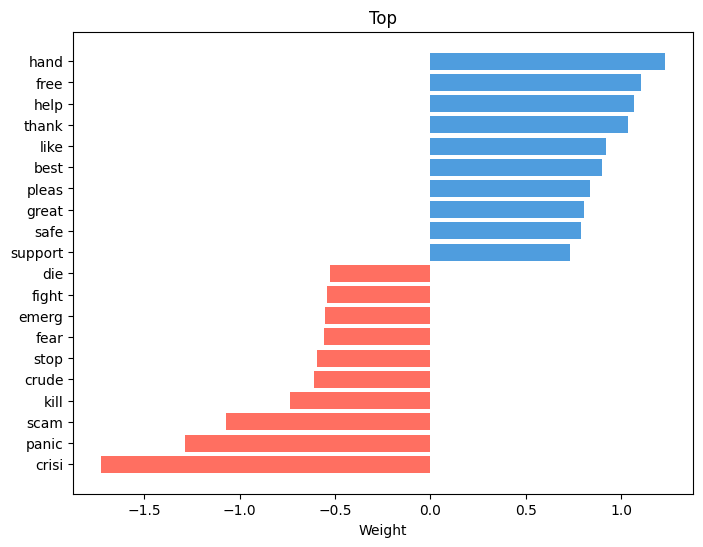

In [192]:
coef = model.coef_[0]
vocab = {v: k for k, v in cv.vocabulary_.items()}
tokens = [vocab[i] for i in range(len(coef))]
weights = pd.DataFrame({'token': tokens, 'weight': coef})

top_positive = weights.sort_values(by='weight', ascending=False).head(10)
top_positive = top_positive.sort_values(by='weight')

top_negative = weights.sort_values(by='weight').head(10)

top_tokens = pd.concat([top_negative, top_positive])

plt.figure(figsize=(8,6))
colors = ['#FF6F61'] * 10 + ['#4F9DDE'] * 10
plt.barh(top_tokens['token'], top_tokens['weight'], color=colors)
plt.xlabel('Weight')
plt.title('Top')
plt.show()

**Ответ:** # Отмасштабированные данные показали более плохие результаты

Негативные токены связаны с негативной окраской

Позитивные токены отражают положительную окраску

Модель корректно выделяет эмоциональную окраску твитов

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [193]:
features = ['UserName', 'ScreenName']
for feat in features:
    print(len(train[feat].unique()))

23410
23410


**Ответ:** # Признаки UserName и ScreenName содержат слишком много уникальных значений, что плохо скажется на работе модели и создаст шум

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [194]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format = 'mixed')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format = 'mixed')

In [195]:
train_pos = train[train['Sentiment'] == 'Positive']
train_neg = train[train['Sentiment'] == 'Negative']

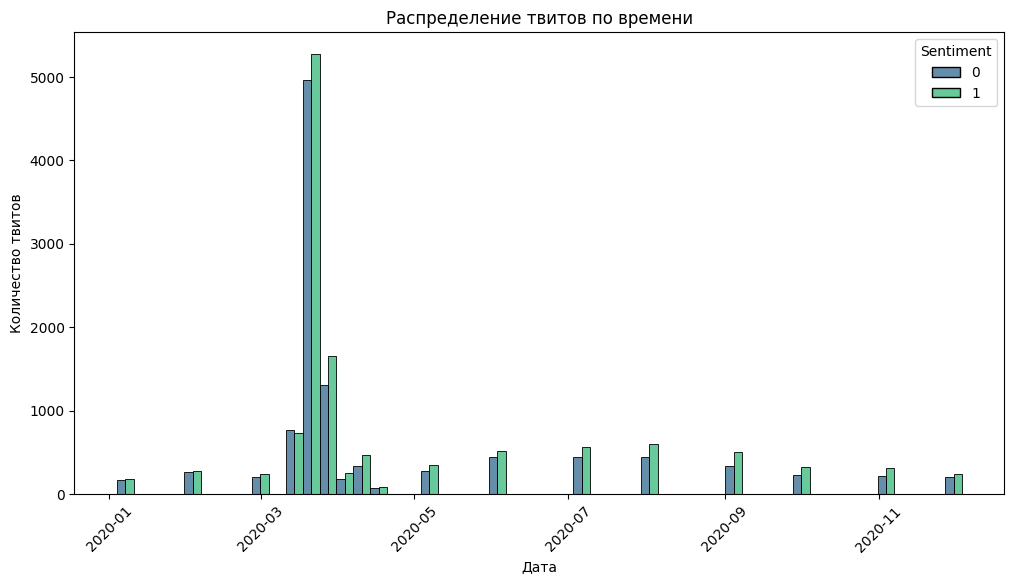

In [196]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', multiple='dodge', palette='viridis', bins=50)
plt.title('Распределение твитов по времени')
plt.xlabel('Дата')
plt.ylabel('Количество твитов')
plt.xticks(rotation=45)
plt.show()

Заметим, что в какие то месяцы количество негативынх твитов значительно выше, а значит этот признак может положительно повлиять на качество моедли

In [197]:
# Выделим месяц из даты и добавим к к матрице с отскалированными признаками
train['TweetMonth'] = train['TweetAt'].dt.month
test['TweetMonth'] = test['TweetAt'].dt.month
# закодируем новый категориальный признак

encoder = OneHotEncoder(drop='first', sparse_output=False)

# Преобразуем месяцы для тренировочной и тестовой выборки
train_month_ohe = encoder.fit_transform(train[['TweetMonth']])
test_month_ohe = encoder.transform(test[['TweetMonth']])

# Получаем имена столбцов
columns = encoder.get_feature_names_out(input_features=['TweetMonth'])

# Соединяем
X_train_final = pd.concat([pd.DataFrame(cv_features_scaled_train.toarray()),
                           pd.DataFrame(train_month_ohe, columns=columns)], axis=1)

X_test_final = pd.concat([pd.DataFrame(cv_features_scaled_test.toarray()),
                          pd.DataFrame(test_month_ohe, columns=columns)], axis=1)

print(X_train_final.shape)
print(X_test_final.shape)

(23410, 3671)
(10034, 3671)


In [198]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,TweetMonth
25621,35178,80130,Unknown,2020-06-04,Why we still want to buy so much stuff during ...,1,6
30135,40819,85771,"Boston, MA HQ",2020-10-04,With driving even more usage a strong strategy...,1,10
28899,39249,84201,India,2020-09-04,@Canon_India I am very happy.. Great job by @C...,1,9
5989,11068,56020,"Mayfair, London, UK",2020-03-19,The U.S national debt will likely exceed $30 T...,0,3
4367,9109,54061,WNC,2020-03-18,"Finally got to the grocery store. Honestly, wh...",1,3


In [199]:
X_train_final.head()

,0,1,2,3,4,5,6,7,8,9,...,TweetMonth_3,TweetMonth_4,TweetMonth_5,TweetMonth_6,TweetMonth_7,TweetMonth_8,TweetMonth_9,TweetMonth_10,TweetMonth_11,TweetMonth_12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

In [201]:
model = LogisticRegression(random_state = RANDOM_STATE)
print(f"Кросс-валидация с Count = {cross_val_score(model, X_train_final, y_train, scoring = 'accuracy', cv = 5).mean()}")
model.fit(X_train_final, y_train)
сv_pred = model.predict(X_test_final)
print(f"accuracy Count на тесте= {accuracy_score(y_test, сv_pred)}")

Кросс-валидация с Count = 0.8267407090986758
accuracy Count на тесте= 0.8433326689256527


**Ответ:** # Качество модели незначительно ухудшилось, а значит признак только мешает модели



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [202]:
print(len(train['Location'].unique()))

7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [203]:
location_counts = train['Location'][train['Location'] != 'Unknown'].value_counts().head(10)

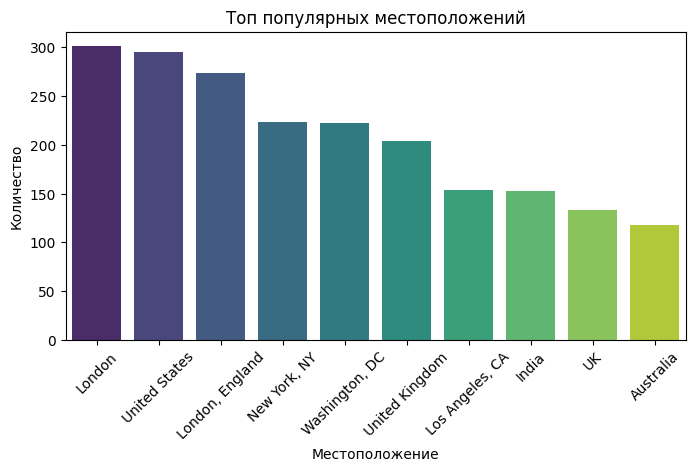

In [204]:
plt.figure(figsize=(8, 4))
sns.barplot(x=location_counts.index, y=location_counts.values, palette='viridis')

plt.title('Топ популярных местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [205]:
def extract(location):
    if ',' in location:
        return location.split(',')[-1].strip()
    return location

train['WiderLocation'] = train['Location'].apply(extract)
test['WiderLocation'] = test['Location'].apply(extract)
wider_location = train[train['Location'] != 'Unknown']['WiderLocation'].value_counts()
len(wider_location)

4765

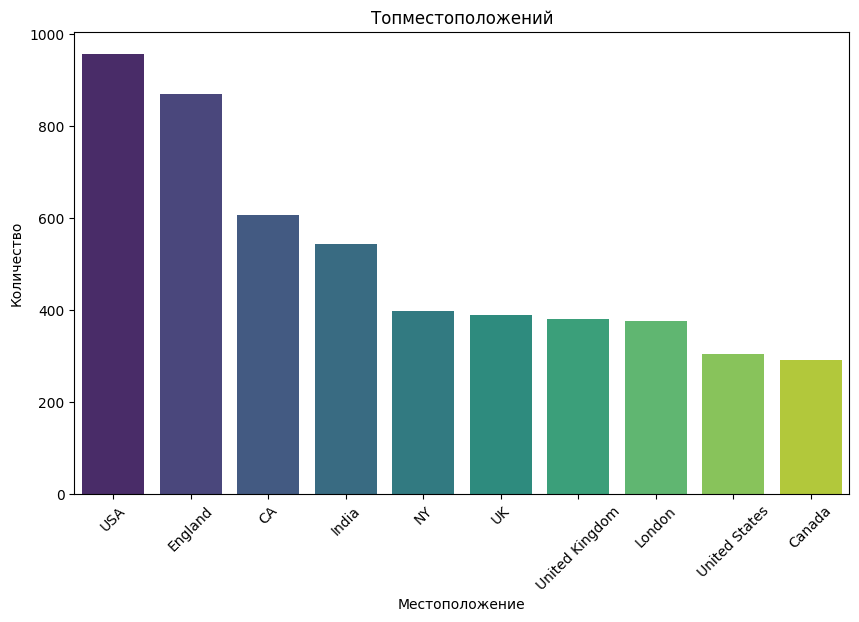

In [206]:
plt.figure(figsize=(10, 6))
sns.barplot(x=wider_location.head(10).index, y=wider_location.head(10).values, palette='viridis')

plt.title('Топместоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [207]:

location_counts = train['WiderLocation'].value_counts()
location_counts_test = test['WiderLocation'].value_counts()

frequent_locations = location_counts[location_counts > 1].index.tolist()
frequent_locations_test = location_counts_test[location_counts_test > 1].index.tolist()

train['WiderLocationFiltered'] = train['WiderLocation'].apply(lambda x: x if x in frequent_locations else 'Other')
test['WiderLocationFiltered'] = test['WiderLocation'].apply(lambda x: x if x in frequent_locations_test else 'Other')

encoder = OneHotEncoder(sparse_output=False, categories=[frequent_locations + ['Other']], handle_unknown='ignore')

wider_train_ohe = encoder.fit_transform(train[['WiderLocationFiltered']])
wider_test_ohe = encoder.transform(test[['WiderLocationFiltered']])

cols = encoder.get_feature_names_out(input_features=['WiderLocationFiltered'])

X_train_final = pd.concat([pd.DataFrame(cv_features_scaled_train.toarray()),
                           pd.DataFrame(wider_train_ohe, columns=cols)], axis=1)

X_test_final = pd.concat([pd.DataFrame(cv_features_scaled_test.toarray()),
                          pd.DataFrame(wider_test_ohe, columns=cols)], axis=1)

print(f"Количество уникальных значений WiderLocation > 1: {len(frequent_locations)}")

Количество уникальных значений WiderLocation > 1: 1005


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [208]:
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

In [209]:
model = LogisticRegression(random_state = RANDOM_STATE)
print(f"Кросс-валидация с Count = {cross_val_score(model, X_train_final, y_train, scoring = 'accuracy', cv = 5).mean()}")
model.fit(X_train_final, y_train)
сv_pred = model.predict(X_test_final)
print(f"accuracy Count на тесте= {accuracy_score(y_test, сv_pred)}")

Кросс-валидация с Count = 0.8269970098248611
accuracy Count на тесте= 0.8461231811839744


**Ответ:** # Качество модели незначтельно улучшилось, но это почти незаметно и можно сказать, что признак оказался бесполезным